<img src="https://www.bestdesigns.co/uploads/inspiration_images/4350/990__1511457498_404_walmart.png" alt="WALMART LOGO" />

# Walmart : predict weekly sales

## Company's Description 📇

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores from the United States, headquartered in Bentonville, Arkansas. The company was founded by Sam Walton in 1962.

## Project 🚧

Walmart's marketing service has asked you to build a machine learning model able to estimate the weekly sales in their stores, with the best precision possible on the predictions made. Such a model would help them understand better how the sales are influenced by economic indicators, and might be used to plan future marketing campaigns.

## Goals 🎯

The project can be divided into three steps:

- Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning
- Part 2 : train a **linear regression model** (baseline)
- Part 3 : avoid overfitting by training a **regularized regression model**

## Scope of this project 🖼️

For this project, you'll work with a dataset that contains information about weekly sales achieved by different Walmart stores, and other variables such as the unemployment rate or the fuel price, that might be useful for predicting the amount of sales. The dataset has been taken from a Kaggle competition, but we made some changes compared to the original data. Please make sure that you're using **our** custom dataset (available on JULIE). 🤓

## Deliverable 📬

To complete this project, your team should: 

- Create some visualizations
- Train at least one **linear regression model** on the dataset, that predicts the amount of weekly sales as a function of the other variables
- Assess the performances of the model by using a metric that is relevant for regression problems
- Interpret the coefficients of the model to identify what features are important for the prediction
- Train at least one model with **regularization (Lasso or Ridge)** to reduce overfitting


## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Part 1 : EDA and data preprocessing

Start your project by exploring your dataset : create figures, compute some statistics etc...

Then, you'll have to make some preprocessing on the dataset. You can follow the guidelines from the *preprocessing template*. There will also be some specific transformations to be planned on this dataset, for example on the *Date* column that can't be included as it is in the model. Below are some hints that might help you 🤓

 #### Preprocessing to be planned with pandas

 **Drop lines where target values are missing :**
 - Here, the target variable (Y) corresponds to the column *Weekly_Sales*. One can see above that there are some missing values in this column.
 - We never use imputation techniques on the target : it might create some bias in the predictions !
 - Then, we will just drop the lines in the dataset for which the value in *Weekly_Sales* is missing.
 
**Create usable features from the *Date* column :**
The *Date* column cannot be included as it is in the model. Either you can drop this column, or you will create new columns that contain the following numeric features : 
- *year*
- *month*
- *day*
- *day of week*

**Drop lines containing invalid values or outliers :**
In this project, will be considered as outliers all the numeric features that don't fall within the range : $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. This concerns the columns : *Temperature*, *Fuel_price*, *CPI* and *Unemployment*
 


**Target variable/target (Y) that we will try to predict, to separate from the others** : *Weekly_Sales*

 **------------**

 #### Preprocessings to be planned with scikit-learn

 **Explanatory variables (X)**
We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

 - Categorical variables : Store, Holiday_Flag
 - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek

### Part 2 : Baseline model (linear regression)
Once you've trained a first model, don't forget to assess its performances on the train and test sets. Are you satisfied with the results ?
Besides, it would be interesting to analyze the values of the model's coefficients to know what features are important for the prediction. To do so, the `.coef_` attribute of scikit-learn's LinearRegression class might be useful. Please refer to the following link for more information 😉 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

### Part 3 : Fight overfitting
In this last part, you'll have to train a **regularized linear regression model**. You'll find below some useful classes in scikit-learn's documentation :
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

**Bonus question**

In regularized regression models, there's a hyperparameter called *the regularization strength* that can be fine-tuned to get the best generalized predictions on a given dataset. This fine-tuning can be done thanks to scikit-learn's GridSearchCV class : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Also, you'll find here some examples of how to use GridSearchCV together with Ridge or Lasso models : https://alfurka.github.io/2018-11-18-grid-search/

In [73]:
import pandas as pd , numpy as np 
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.formula.api import ols


from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer , SimpleImputer
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error , r2_score

from sklearn.linear_model import LinearRegression , Ridge , Lasso , ElasticNet
from BestSetUp import BestSetUp # My optimization class

import warnings
warnings.filterwarnings('ignore')

np.random.seed(12345)

In [74]:
df = pd.read_csv('Walmart_Store_sales.csv' , parse_dates=['Date'] , infer_datetime_format=True) # Load data , preprocess the dates
df_copy = df.copy(deep=True) # Create a copy before modifying
df = df[['Date' , 'Store' , 'Temperature' , 'Fuel_Price' , 'CPI' , 'Unemployment' , 'Holiday_Flag' , 'Weekly_Sales']] # Re-order columns 
df = df[(df['Weekly_Sales'].isna() == False) & (df['Date'].isna() == False)] # Drop the rows where the target is missing
df = df.sort_values(by='Date' , ascending=True) # Sort by date

# Decompose features from the date column , for the model to be able to use it 
df['Year'] = df['Date'].dt.year 
df['Day_of_week'] = df['Date'].dt.day_of_week
df['Day_of_month'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df.index = df['Date']
df = df.drop('Date' , axis=1)

# The days of week look weirdly identical , if there is only one , I will drop the column
if df['Day_of_week'].nunique() == 1:
    df = df.drop('Day_of_week' , axis=1)
    
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag,Weekly_Sales,Year,Day_of_month,Month
Date,,,,,,,,,,
2010-02-05,3.0,45.71,2.572,214.424881,7.368,0.0,461622.22,2010,5,2
2010-02-12,1.0,38.51,2.548,211.242170,8.106,1.0,1641957.44,2010,12,2
2010-02-12,8.0,33.34,2.548,214.621419,6.299,1.0,994801.40,2010,12,2
2010-02-19,15.0,NaN,2.909,131.637000,NaN,0.0,660838.75,2010,19,2
2010-02-19,2.0,39.69,2.514,210.945160,NaN,0.0,2124451.54,2010,19,2


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 2010-02-05 to 2012-10-19
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         118 non-null    float64
 1   Temperature   107 non-null    float64
 2   Fuel_Price    107 non-null    float64
 3   CPI           109 non-null    float64
 4   Unemployment  107 non-null    float64
 5   Holiday_Flag  109 non-null    float64
 6   Weekly_Sales  118 non-null    float64
 7   Year          118 non-null    int64  
 8   Day_of_month  118 non-null    int64  
 9   Month         118 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 10.1 KB


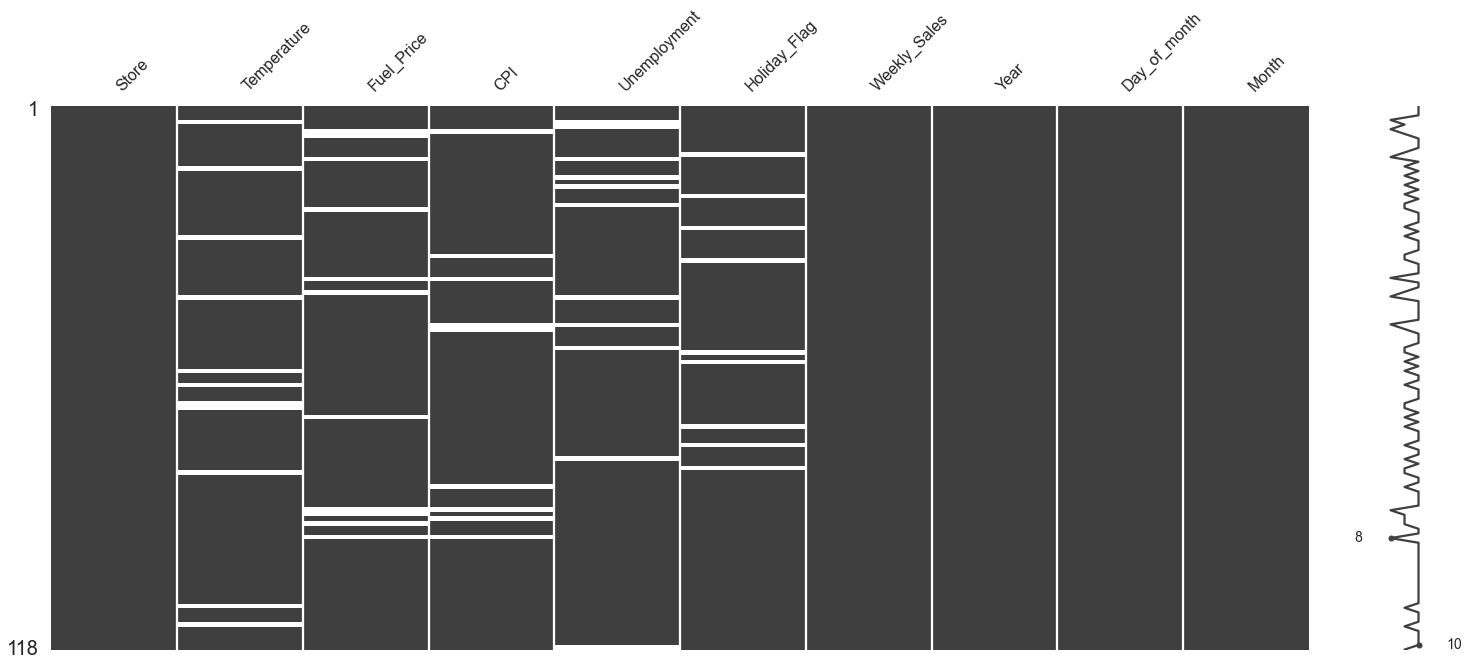

In [76]:
# Check for missing values using a matrix
msno.matrix(df)
plt.show()

In [77]:
# Derive missing values with Iterative imputer
imputer_num = IterativeImputer(estimator=Ridge() , max_iter=5)
imputer_cat = SimpleImputer(strategy='most_frequent')

df[['Temperature' , 'Fuel_Price' , 'CPI' , 'Unemployment']] = imputer_num.fit_transform(df[['Temperature' , 'Fuel_Price' , 'CPI' , 'Unemployment']])
df[['Store' , 'Holiday_Flag']] = imputer_cat.fit_transform(df[['Store' , 'Holiday_Flag']])
df.isna().sum()

Store           0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Holiday_Flag    0
Weekly_Sales    0
Year            0
Day_of_month    0
Month           0
dtype: int64

In [78]:
# Deal with outliers
def remove_outliers(column : str , df=df):

    mean_ = np.mean(df[column])
    std_dev = np.std(df[column])
    threshold = 3 * std_dev
    lower_bound = mean_ - threshold
    upper_bound = mean_ + threshold
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

print('Before removing outliers : ' , len(df))
for col in ['Temperature' , 'Fuel_Price' , 'CPI' , 'Unemployment' , 'Weekly_Sales']:
    df = remove_outliers(column=col)


print('After removing outliers : ' , len(df)) # No value were removed

Before removing outliers :  118
After removing outliers :  118


### EDA

We can see that the decomposed time serie did not capture any insightful pattern.

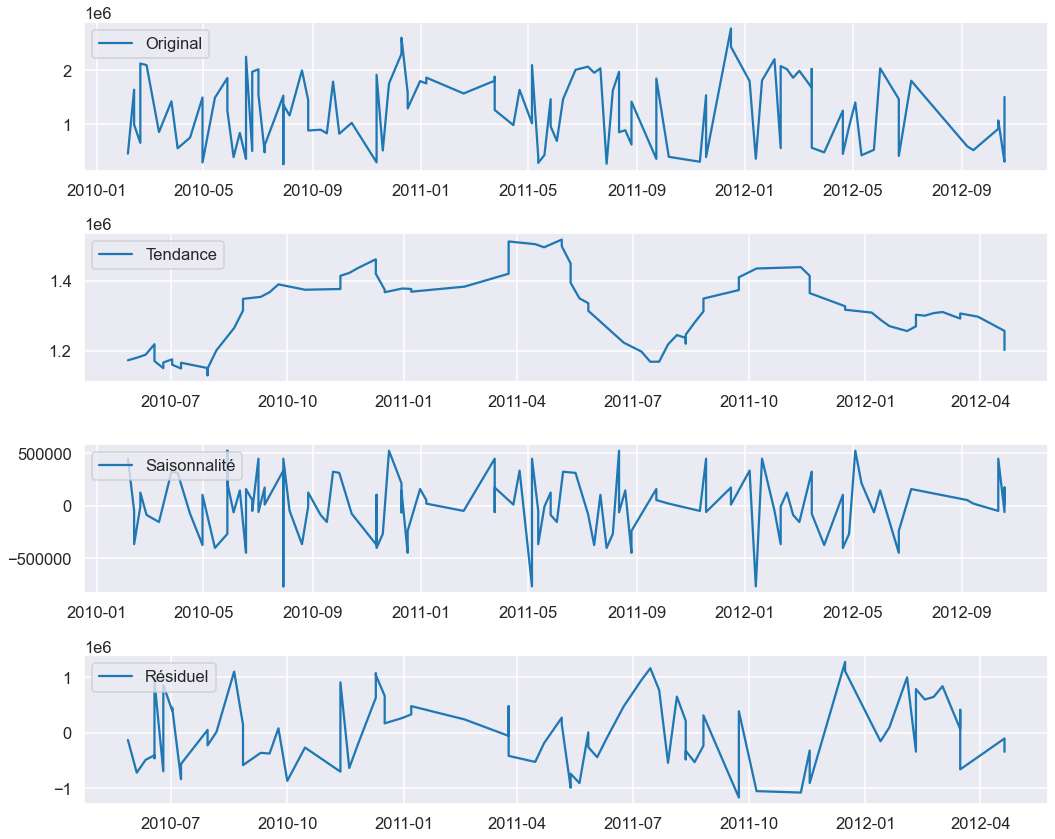

In [79]:
# Time serie decomposition
decomposition = seasonal_decompose(df['Weekly_Sales'], model='additive', period=30)

# Style matters
sns.set_style('darkgrid')
sns.set_context('talk')

# Plot the decomposed components
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(df['Weekly_Sales'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendance')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Saisonnalité')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Résiduel')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

From this visualisation we can see that the target is multimodal ( has two peaks ) and the median and mean are not far from each other , suggesting that there is not a lot of outliers.

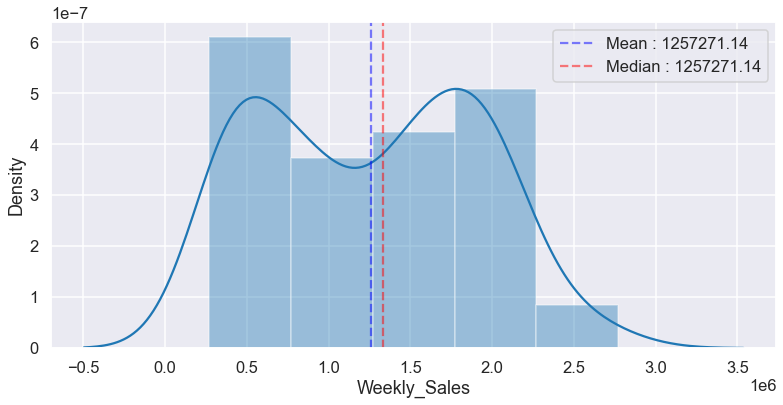

In [80]:
# Distribution of the target variable
mean_target = round(df['Weekly_Sales'].mean() , 2)
median_target = round(df['Weekly_Sales'].median() , 2)

plt.figure(figsize=(13,6))
sns.distplot(df['Weekly_Sales'])
plt.axvline(mean_target , color='blue' , linestyle='--' , alpha=0.5 , label=f'Mean : {mean_target}')
plt.axvline(median_target , color='red' , linestyle='--' , alpha=0.5 , label=f'Median : {mean_target}')
plt.legend()
plt.show()

Our dataset do not suffer from high multicollinearity.

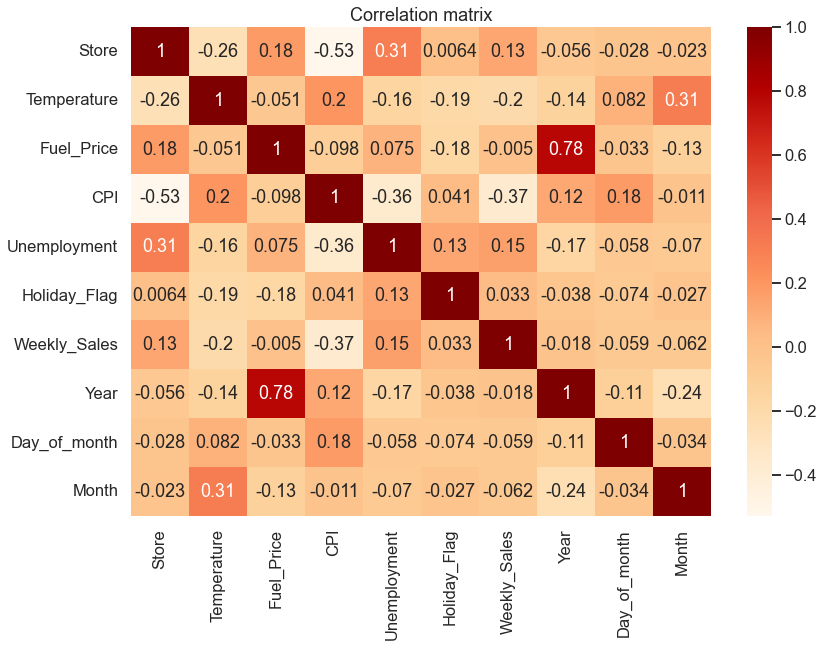

In [81]:
corr_ = df.corr(method='spearman')
plt.figure(figsize=(13,9))
sns.heatmap(corr_ , annot=True , cmap='OrRd')
plt.title('Correlation matrix')
plt.show()

On this graph we can see the most correlated variables (negatively or positively) with weekly sales

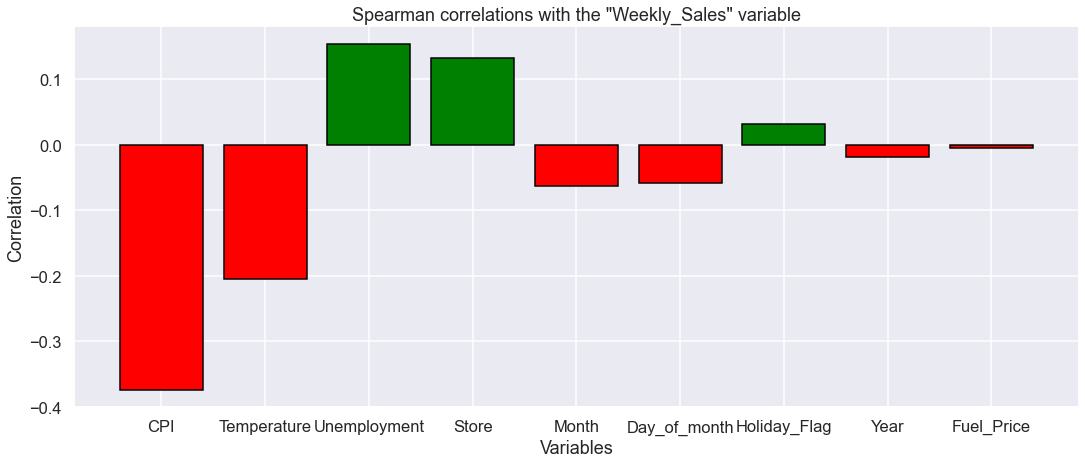

In [82]:
def check_correlation(target : str , df : pd.DataFrame , method : str):
    """Returns a sorted dataframe with the columns names and their correlation with 
    the specified target variable"""
   
    cor = [df[target].corr(df[col] , method=method) for col in df.columns]
    dictio = dict(zip(df.columns , cor))

    to_ret = pd.DataFrame({'columns' : dictio.keys()  , 'correlation_with_the_specified_target' : dictio.values()})\
    .sort_values(by=['correlation_with_the_specified_target'] , ascending=False)[1:]

    to_ret['abs_correlation'] = abs(to_ret['correlation_with_the_specified_target']) 


    return to_ret.sort_values(by='abs_correlation' , ascending=False).drop('abs_correlation' , axis=1)

corr_target = check_correlation(target='Weekly_Sales' , df=df , method='spearman')
colors = ['green' if corr >= 0 else 'red' for corr in corr_target['correlation_with_the_specified_target']]

plt.figure(figsize=(18,7))
plt.bar(x=corr_target['columns'] , height=corr_target['correlation_with_the_specified_target'] , color=colors , edgecolor='black')
plt.title('Spearman correlations with the "Weekly_Sales" variable')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()

## Modeling

We can see the the model fit looks good , with a R-squared of 0.96. Let's analyse it's coefficients ; 
For a categorical predictor variable, the regression coefficient represents the difference in the predicted value of the response variable between the category for which the predictor variable = 0 and the category for which the predictor variable = 1 (let's picture it as dummies variables).
For numerical variables , the coefficients tell us than , for a one unit change in X , the target variable will be multiplied by the coefficient , all other explanatory variables held constant. Before looking at the coefficient , we should also take a look at the p-values for each variables. A p-value of more than 0.05 tells us that the variable is not statisticaly significant in the prediction of the dependant variable.
We can also note that for the OLS model , the store variable is the most important predictive variable for changes in weekly sales.

In [121]:
# Making inference with OLS (Ordinary Least Square)
formula = formula = 'Weekly_Sales ~  Temperature + Fuel_Price + CPI + Year + Day_of_month + Month  + C(Store) + C(Holiday_Flag)'
model = ols(formula=formula , data=df).fit()

print('R-squared (adjusted) : ' , round(model.rsquared_adj , 2))
print(model.summary())

R-squared (adjusted) :  0.96
                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     110.7
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           7.57e-58
Time:                        19:34:37   Log-Likelihood:                -1543.0
No. Observations:                 118   AIC:                             3140.
Df Residuals:                      91   BIC:                             3215.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

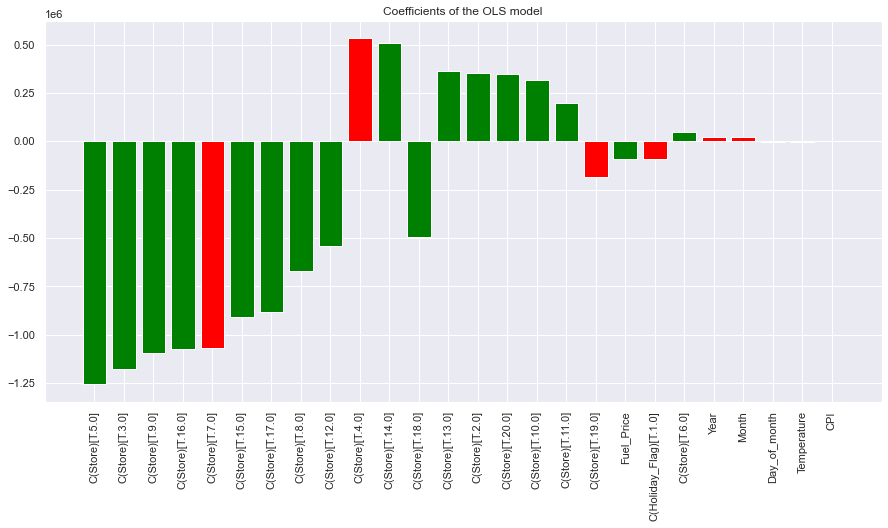

In [122]:
df_ols_results = pd.DataFrame({'Variable' : model.pvalues.keys() , 'p_val' : dict(model.pvalues).values() , 'Coefficient' : dict(model.params).values()})
df_ols_results['Coefficient'] = [float("{:.2f}".format(coef)) for coef in list(df_ols_results['Coefficient'])]
df_ols_results['Significant'] = [1 if pval <= 0.05 else 0 for pval in list(df_ols_results['p_val'])]
df_ols_results['p_val'] = [float("{:.2f}".format(pval)) for pval in list(df_ols_results['p_val'])]
df_ols_results = df_ols_results.iloc[1:] # I don't need the intercept
colors = ['green' if sign == 1 else 'red' for sign in list(df_ols_results['Significant'])]
df_ols_results['abs_coef'] = abs(df_ols_results['Coefficient'])
df_ols_results = df_ols_results.sort_values(by='abs_coef' , ascending=False).drop('abs_coef' , axis=1)

with sns.plotting_context('notebook'):
    plt.figure(figsize=(15,7))
    plt.bar(x=df_ols_results['Variable'] , height=df_ols_results['Coefficient'] , color=colors)
    plt.xticks(rotation=90)
    plt.title('Coefficients of the OLS model')

Now that I have done some inference using OLS , I will build two linear models using sklearn , and assess the predictive power of both.

In [85]:
df['Store'] = df['Store'].astype(object)

models = [LinearRegression() , Lasso() , Ridge() , ElasticNet()]
scalers = [StandardScaler() , MinMaxScaler()]

# Find the best set up for the problem using my custom class
best_set_up = BestSetUp(X=df.drop(['Weekly_Sales' , 'Month' , 'Day_of_month' , 'Year'] , axis=1) , y=df[['Weekly_Sales']],
                        models=models , scalers=scalers , n_cv=5)

best_string = best_set_up.get_best_setup() # Get a string with the best set up
print(best_string)
X , y = best_set_up.get_X_and_y()
X[['Month' , 'Day_of_month' , 'Year']] = df[['Month' , 'Day_of_month' , 'Year']]
X.head()

Best model : Lasso()
Best scaler : StandardScaler()
Best categorical processing : Target encoding        
With or without outliers : Better keep the outliers


,Store,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag,Month,Day_of_month,Year
Date,,,,,,,,,
2010-02-05,4.033533e+05,-0.877019,-1.557871,0.969120,-0.193016,-0.269680,2,5,2010
2010-02-12,1.550101e+06,-1.299547,-1.609812,0.885872,0.268541,3.708099,2,12,2010
2010-02-12,8.887541e+05,-1.602946,-1.609812,0.974260,-0.861586,3.708099,2,12,2010
2010-02-19,6.422821e+05,-0.174699,-0.828530,-1.196296,0.365809,-0.269680,2,19,2010
2010-02-19,1.982229e+06,-1.230299,-1.683396,0.878104,-0.441102,-0.269680,2,19,2010


In [86]:
baseline_model = LinearRegression() 
lasso = Lasso()

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2)
baseline_model.fit(X_train , y_train)
lasso.fit(X_train , y_train)

preds = baseline_model.predict(X_test)
print('RMSE LinearRegression : ' , round(mean_squared_error(y_test , preds , squared=False) , 3))
print('Mean Absolute Percentage Error LinearRegression : ' , round(mean_absolute_percentage_error(y_test , preds) , 3) , '%')
print('R squarred best model : ' , r2_score(y_test , preds))

print('\n')

preds_lasso = lasso.predict(X_test)
print('RMSE Lasso : ' , round(mean_squared_error(y_test , preds_lasso , squared=False) , 3))
print('Mean Absolute Percentage Error Lasso : ' , round(mean_absolute_percentage_error(y_test , preds_lasso) , 3) , '%')
print('R squarred best model : ' , r2_score(y_test , preds_lasso))

RMSE LinearRegression :  134480.875
Mean Absolute Percentage Error LinearRegression :  0.099 %
R squarred best model :  0.9578025309637098


RMSE Lasso :  134479.831
Mean Absolute Percentage Error Lasso :  0.099 %
R squarred best model :  0.9578031863745871


## Lasso model optimisation

In [87]:
alpha_params = np.arange(0.001 , 20_000, 0.1)
params = {'alpha' : alpha_params}

grid = GridSearchCV(estimator=Lasso(max_iter=5000) , param_grid=params , n_jobs=-1 , cv=5 , scoring='neg_mean_squared_error')
grid.fit(X , y)

best_model = Lasso(**grid.best_params_ , max_iter=5000)

In [88]:
# Compare the results of the optimized model with the vanilla Lasso model
best_model.fit(X_train , y_train)
preds = best_model.predict(X_test)

print('RMSE optimized Lasso : ' , round(mean_squared_error(y_test , preds , squared=False) , 3))
print('Mean Absolute Percentage Error optimized Lasso : ' , round(mean_absolute_percentage_error(y_test , preds) , 3) , '%')
print('R squarred best model : ' , r2_score(y_test , preds))

RMSE optimized Lasso :  134340.847
Mean Absolute Percentage Error optimized Lasso :  0.094 %
R squarred best model :  0.9578903617173598


Lasso is a linear regression with an l1 regularization, which performs a kind of feature selection, giving much more weight to some variables than to others. Although this model is the one that performs best in this case, it can give rise to generalization problems, unlike the more uniform l2 regularization. As we can see in the two following graphics (with a ridge regression , which uses the l2 regularization).
We can also note that the Lasso model temperature and date as his main predictive features. This seems counter-intuitive, as these aren't the most correlated variables to weekly sales, but works surprisingly well.

Text(0.5, 1.0, 'Feature importance according to the Lasso model.')

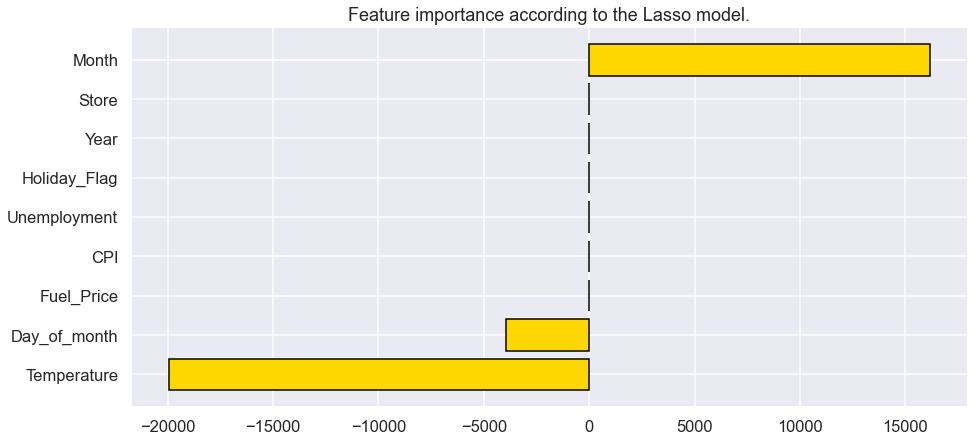

In [101]:
to_plot = dict(zip(best_model.feature_names_in_ , best_model.coef_))
to_plot = dict(sorted(to_plot.items(), key=lambda x:x[1]))

plt.figure(figsize=(15,7))
plt.barh(list(to_plot.keys()) , list(to_plot.values()) , color='gold' , edgecolor='black')
plt.title('Feature importance according to the Lasso model.')

RMSE optimized Lasso :  134325.986
Mean Absolute Percentage Error optimized Lasso :  0.098 %
R squarred best model :  0.9578996775290931


Text(0.5, 1.0, 'Feature importance according to the Ridge model.')

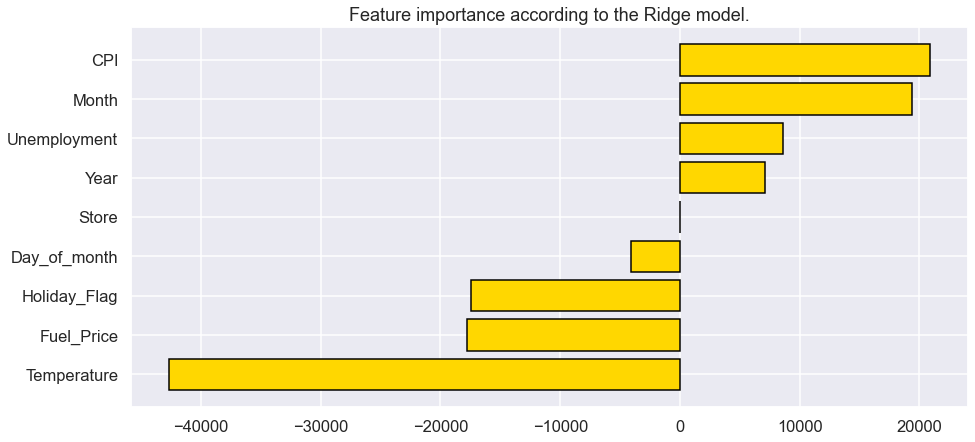

In [120]:
ridge = Ridge()
ridge.fit(X_train , y_train)
preds = ridge.predict(X_test)

print('RMSE optimized Lasso : ' , round(mean_squared_error(y_test , preds , squared=False) , 3))
print('Mean Absolute Percentage Error optimized Lasso : ' , round(mean_absolute_percentage_error(y_test , preds) , 3) , '%')
print('R squarred best model : ' , r2_score(y_test , preds))

to_plot = dict(zip(ridge.feature_names_in_ , ridge.coef_[0]))
to_plot = dict(sorted(to_plot.items(), key=lambda x:x[1])) 

plt.figure(figsize=(15,7))
plt.barh(list(to_plot.keys()) , list(to_plot.values()) ,  color='gold' , edgecolor='black')
plt.title('Feature importance according to the Ridge model.')